En este notebook se mostrará el código referente al entrenamiento del modelo, así como del análisis de resultados y ejecución del programa con el modelo generado.

En primer lugar, se muestra el código utilizado para el entrenamiento de nuestro modelo:

In [ ]:
# Instalación de paquetes adicionales
!pip3 install peft
!pip3 install scikit-learn
!pip3 install datasets
!pip3 install matplotlib
!pip3 install seaborn

In [1]:
# Importaciones

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import pandas as pd
import numpy as np
import peft
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, Trainer, TrainingArguments, pipeline
from peft import LoraConfig, PeftModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import load_dataset, Dataset, DatasetDict
from huggingface_hub import snapshot_download

C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Realizadas las importaciones, se procede a la descarga del modelo pre-entrenado especializado en clasificación de secuencias

In [37]:
nombre_modelo = 'PlanTL-GOB-ES/roberta-large-bne-massive'
#snapshot_download(repo_id=nombre_modelo, cache_dir='./huggingface_mirror')

In [38]:
nombre_fichero = os.getcwd() + '\\ficheros_excel\\MODELO_ENTRENAMIENTO.xlsx'
df_modelo_entrenamiento = pd.read_excel(io=nombre_fichero, sheet_name='MODELO_ENTRENAMIENTO', index_col=None)
df_modelo_entrenamiento = df_modelo_entrenamiento[['Test', 'YAML']]

# Se renombran las columnas, ya que de lo contrario puede dar errores durante el entrenamiento
df_modelo_entrenamiento.columns = ['text', 'label']
etiquetas = df_modelo_entrenamiento['label'].tolist()
print('Total etiquetas:', len(list(set(etiquetas))))

# Las etiquetas deben ser números dentro del transformer y se han de crear mapas de los ids/identificadores esperados con etiquetas_a_id e ids_a_etiquetas
etiquetas_a_id = {}
ids_a_etiquetas = {}
numero_de_etiquetas = 0
i = 0
while i < len(etiquetas):
    # Se comprueba si la etiqueta no existe en el diccionario
    if etiquetas[i] not in list(etiquetas_a_id.keys()):
        # De no existir, se añade en el dicionario
        ids_a_etiquetas[numero_de_etiquetas] = etiquetas[i]
        etiquetas_a_id[etiquetas[i]] = numero_de_etiquetas
        numero_de_etiquetas = numero_de_etiquetas + 1
        
    i = i + 1

# Se procede a cambiar los textos por su valor numérico asignado
listado_etiquetas = []
i = 0
while i < len(etiquetas):
    listado_etiquetas.append(etiquetas_a_id[etiquetas[i]])
    i = i + 1

# Se modifica la columna de etiquetas para que contenga los valores numéricos correspondientes
df_modelo_entrenamiento['label'] = listado_etiquetas

print(df_modelo_entrenamiento.info())

Total etiquetas: 251
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7706 entries, 0 to 7705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7706 non-null   object
 1   label   7706 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.5+ KB
None


In [39]:
# Se crea la configuración para modificar la capa de clasificación de nuestro modelo preentrenado al de nuestro modelo
nueva_configuracion_modelo = AutoConfig.from_pretrained(nombre_modelo, num_labels=numero_de_etiquetas, id2label=ids_a_etiquetas, label2id=etiquetas_a_id, cache_dir='./huggingface_mirror')


In [40]:
# Se obtiene el modelo y tokenizador del modelo ya preentrenado
modelo_roberta = AutoModelForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-large-bne-massive', cache_dir='./huggingface_mirror', local_files_only=True)
#print(modelo_roberta)

modelo_roberta.classifier.out_proj = torch.nn.Linear(modelo_roberta.classifier.out_proj.in_features, numero_de_etiquetas, bias=True)
modelo_roberta.num_labels = numero_de_etiquetas
modelo_roberta.config = nueva_configuracion_modelo

print('Número de etiquetas del modelo:', modelo_roberta.config.num_labels)

print('\n', modelo_roberta)
tokenizador_roberta = AutoTokenizer.from_pretrained(nombre_modelo, cache_dir='./huggingface_mirror', local_files_only=True, from_pt=True)

Número de etiquetas del modelo: 251

 RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_feat

In [6]:
def tokenizador_texto(textos, tokenizador):
    texto = textos['text']
    textos_tokenizados = tokenizador(texto, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    return textos_tokenizados

In [42]:
dataset = Dataset.from_pandas(df_modelo_entrenamiento, split='train')
dataset = dataset.train_test_split(shuffle=True, seed=42, test_size=0.2)
print('Dataset:', dataset)

if tokenizador_roberta.pad_token is None:
    tokenizador_roberta.add_special_tokens({'pad_token': '[PAD]'})
    modelo_roberta.resize_token_embeddings(len(tokenizador_roberta))

dataset_tokenizado = dataset.map(tokenizador_texto, batched=True, fn_kwargs={'tokenizador': tokenizador_roberta})
print('Dataset tokenizado:', dataset_tokenizado)
print('\nCaracterísticas Dataset tokenizado:', dataset_tokenizado['train'].features)

Dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6164
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1542
    })
})


Map: 100%|████████████████████████████████████████████████████████████████| 1542/1542 [00:00<00:00, 3678.02 examples/s]

Dataset tokenizado: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6164
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1542
    })
})

Características Dataset tokenizado: {'text': Value('string'), 'label': Value('int64'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


Hecha ya la separaciòn en train y test, se procede a comprobar la distribución de clases en el conjunto de train o entrenamiento. Dada la cantidad de clases existentes, se mostrarán los datos entre varias gráficas para una mejor visualización.

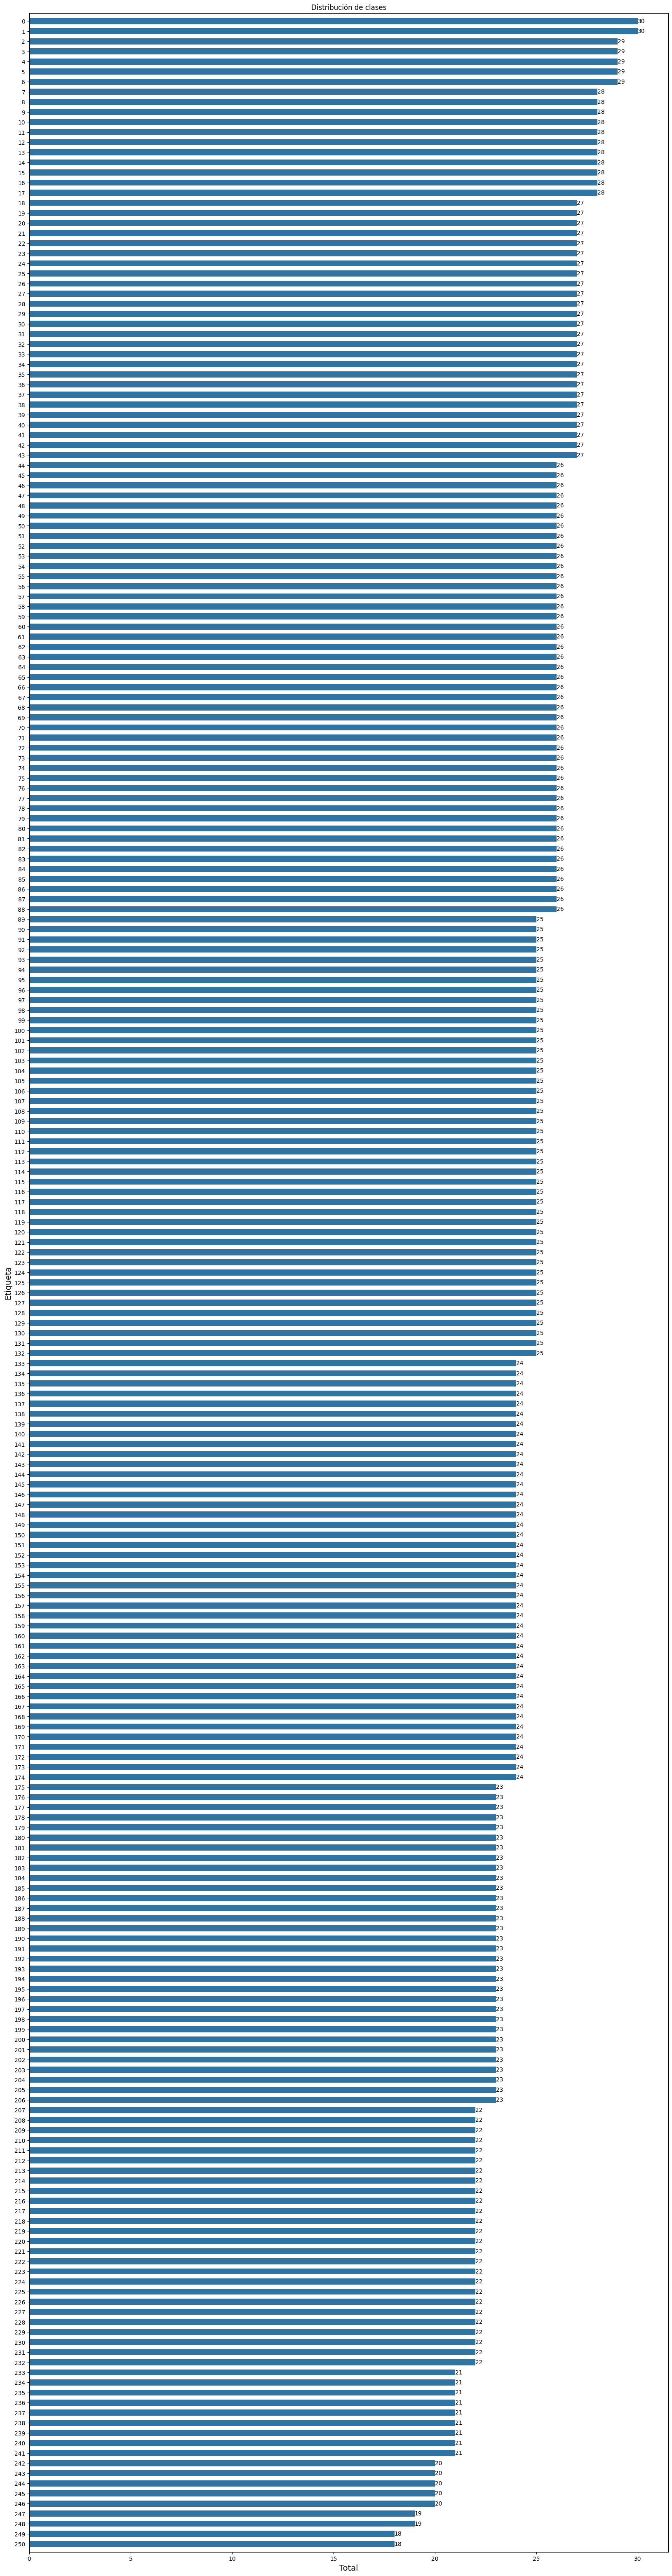

In [44]:
# Se crea DataFrame a partir de un Dataset
df_entrenamiento = pd.DataFrame(dataset_tokenizado['train'])

# Se ordenan las etiquetas
df_entrenamiento.sort_values(by=['label'], inplace=True)

figura, ejes = plt.subplots()
figura.set_figheight(80)
sns.barplot(y=df_entrenamiento['label'].unique(), x=df_entrenamiento['label'].value_counts(), orient='h', width=0.6)
ejes.set_xlabel('Total', fontsize=14)
ejes.set_ylabel('Etiqueta', fontsize=14)
ejes.set_title('Distribución de clases')
ejes.bar_label(ejes.containers[0])
plt.margins(y=0.002, tight=True)
plt.show()

In [45]:
# En la siguiente línea, se busca realizar padding en todas las secuencias, de manera que todas coincidan en longitud con la más larga. Esto es de utilizad para conseguir una mayor eficiencia
data_collator = DataCollatorWithPadding(tokenizer=tokenizador_roberta, padding=True)
#accuracy = evaluate.load("accuracy")

configuracion_peft = LoraConfig(task_type='SEQ_CLS', r=4, lora_alpha=32, lora_dropout=0.01, target_modules=['query'])
modelo_peft = peft.get_peft_model(model=modelo_roberta, peft_config=configuracion_peft)

# Se muestran las cantidades de parámetros, siendo dichos parámetros el total, el número de parámetros entrenables y qué porcentaje de éstos se entrenará
modelo_peft.print_trainable_parameters()

trainable params: 1,503,483 || all params: 357,117,430 || trainable%: 0.4210


In [7]:
def obtener_metricas(p):
    predicciones, etiquetas = p
    predicciones = np.argmax(predicciones, axis=1)
    accuracy = accuracy_score(etiquetas, predicciones)
    precision = precision_score(etiquetas, predicciones, average='weighted')
    recall = recall_score(etiquetas, predicciones, average='weighted')
    f1 = f1_score(etiquetas, predicciones, average='weighted')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [106]:
training_args = TrainingArguments(
    output_dir=nombre_modelo + '-custom-lora',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch',
    push_to_hub=False
)

trainer = Trainer(
    model=modelo_peft,
    args=training_args,
    train_dataset=dataset_tokenizado['train'],
    eval_dataset=dataset_tokenizado['test'],
    tokenizer=tokenizador_roberta,
    data_collator=data_collator,
    compute_metrics=obtener_metricas
)

C:\Users\jmarrieta\AppData\Local\Temp\ipykernel_6964\2216510331.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [71]:
trainer.train()
modelo_peft.to('cpu')
modelo_peft.eval()
modelo_peft.save_pretrained(nombre_modelo + '_peft')
trainer.save_model()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,5.271197,0.053178,0.034111,0.053178,0.030507
2,5.362000,4.985578,0.142672,0.126474,0.142672,0.105968
3,4.944900,4.772859,0.214656,0.193733,0.214656,0.172068
4,4.644400,4.644375,0.246433,0.242649,0.246433,0.202802
5,4.644400,4.601132,0.255512,0.255058,0.255512,0.213553


C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jmarrieta\AppDat

TypeError: save_metrics() missing 2 required positional arguments: 'split' and 'metrics'

In [107]:
# Se guarda el modelo fusionado
modelo_peft_fusionado = modelo_peft.merge_and_unload()
modelo_peft_fusionado.save_pretrained('roberta-large-bne-massive_peft_fusionado')

In [72]:
# Evaluamos el modelo
resultados_evaluacion = trainer.evaluate()
print(resultados_evaluacion)

C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 4.601131916046143, 'eval_accuracy': 0.25551232166018156, 'eval_precision': 0.2550581544646944, 'eval_recall': 0.25551232166018156, 'eval_f1': 0.21355321292992166, 'eval_runtime': 3936.1073, 'eval_samples_per_second': 0.392, 'eval_steps_per_second': 0.025, 'epoch': 5.0}


C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   eval_loss  eval_accuracy  eval_precision  eval_recall   eval_f1  \
0   5.271197       0.053178        0.034111     0.053178  0.030507   
1        NaN            NaN             NaN          NaN       NaN   
2   4.985578       0.142672        0.126474     0.142672  0.105968   
3        NaN            NaN             NaN          NaN       NaN   
4   4.772859       0.214656        0.193733     0.214656  0.172068   
5        NaN            NaN             NaN          NaN       NaN   
6   4.644375       0.246433        0.242649     0.246433  0.202802   
7   4.601132       0.255512        0.255058     0.255512  0.213553   
8        NaN            NaN             NaN          NaN       NaN   
9   4.601132       0.255512        0.255058     0.255512  0.213553   

   eval_runtime  eval_samples_per_second  eval_steps_per_second     epoch  \
0     4594.8294                    0.336                  0.021  1.000000   
1           NaN                      NaN                    NaN  1.295337  

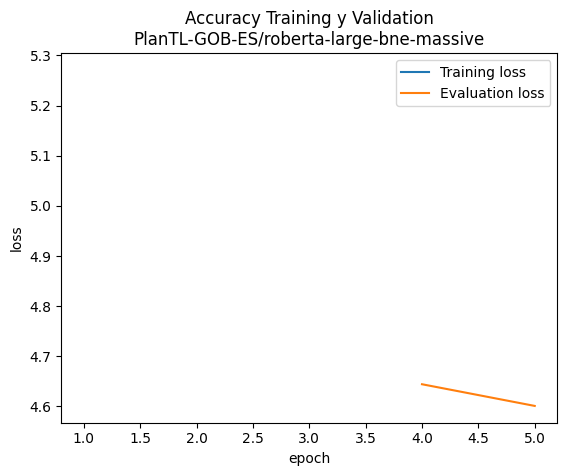

In [89]:
def mostrar_graficas(metricas, titulo):
    df_metricas = pd.DataFrame(metricas)
    print(df_metricas)
    #df_metricas.dropna(subset=['eval_loss'], inplace=True)
    figura, ejes = plt.subplots()
    plt.title(titulo)
    ejes.plot(df_metricas['epoch'], df_metricas['train_loss'], label='Training loss')
    ejes.plot(df_metricas['epoch'], df_metricas['eval_loss'], label='Evaluation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    ejes.legend()
    plt.show()

mostrar_graficas(trainer.state.log_history, 'Accuracy Training y Validation\nPlanTL-GOB-ES/roberta-large-bne-massive')

In [ ]:
def generar_matriz_de_confusion(y_verdadero, y_predicho):
    # Se crea la matriz de confusión
    matriz_de_confusion = confusion_matrix(y_verdadero, y_predicho)

    # Se crea la figura y se muestra la matriz de confusión mediante un mapa de calor
    plt.figure(fig_size=(300,300))
    sns.heatmap(matriz_de_confusion, annot=True, fmt='d', cmap='blues', xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title('Matriz de confusión')
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.show()

predicciones = trainer.predict(dataset_tokenizado['test'])
etiquetas = dataset_tokenizado['test']['label']
generar_matriz_de_confusion(etiquetas, predicciones.predictions.argmax(-1))

Se prueba a continuación a generar un modelo a partir del modelo pre-entrenado BETO, con los mismos parámetros con los que se entrenó el modelo PlanTL-GOB-ES/roberta-large-bne-massive

In [ ]:
nombre_modelo_beto = 'dccuchile/albert-base-10-spanish-finetuned-mldoc'
snapshot_download(repo_id=nombre_modelo_beto, cache_dir='./huggingface_mirror')

In [94]:
# Se crea la configuración para modificar la capa de clasificación de nuestro modelo preentrenado al de nuestro modelo
nueva_configuracion_modelo_beto = AutoConfig.from_pretrained(nombre_modelo_beto, num_labels=numero_de_etiquetas, id2label=ids_a_etiquetas, label2id=etiquetas_a_id, cache_dir='./huggingface_mirror')


In [95]:
# Se obtiene el modelo y tokenizador del modelo ya preentrenado
modelo_beto = AutoModelForSequenceClassification.from_pretrained(nombre_modelo_beto, cache_dir='./huggingface_mirror', local_files_only=True)
print(modelo_beto)

modelo_beto.classifier = torch.nn.Linear(modelo_beto.classifier.in_features, numero_de_etiquetas, bias=True)
modelo_beto.num_labels = numero_de_etiquetas
modelo_beto.config = nueva_configuracion_modelo

#print('Número de etiquetas del modelo:', modelo_roberta.config.num_labels)

print('\n', modelo_beto)
tokenizador_beto = AutoTokenizer.from_pretrained(nombre_modelo_beto, cache_dir='./huggingface_mirror', local_files_only=True, from_pt=True)


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(31000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [101]:
if tokenizador_beto.pad_token is None:
    tokenizador_beto.add_special_tokens({'pad_token': '[PAD]'})
    modelo_beto.resize_token_embeddings(len(tokenizador_beto))

dataset_tokenizado = dataset.map(tokenizador_texto, batched=True, fn_kwargs={'tokenizador': tokenizador_beto})
print('Dataset tokenizado:', dataset_tokenizado)
print('\nCaracterísticas Dataset tokenizado:', dataset_tokenizado['train'].features)

Map: 100%|████████████████████████████████████████████████████████████████| 1542/1542 [00:00<00:00, 2455.05 examples/s]

Dataset tokenizado: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6164
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1542
    })
})

Características Dataset tokenizado: {'text': Value('string'), 'label': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}


In [102]:
# En la siguiente línea, se busca realizar padding en todas las secuencias, de manera que todas coincidan en longitud con la más larga. Esto es de utilizad para conseguir una mayor eficiencia
data_collator_beto = DataCollatorWithPadding(tokenizer=tokenizador_beto, padding=True)
#accuracy = evaluate.load("accuracy")

configuracion_peft_beto = LoraConfig(task_type='SEQ_CLS', r=4, lora_alpha=32, lora_dropout=0.01, target_modules=['query'])
modelo_peft_beto = peft.get_peft_model(model=modelo_beto, peft_config=configuracion_peft_beto)

# Se muestran las cantidades de parámetros, siendo dichos parámetros el total, el número de parámetros entrenables y qué porcentaje de éstos se entrenará
modelo_peft_beto.print_trainable_parameters()

trainable params: 199,163 || all params: 12,203,766 || trainable%: 1.6320


In [103]:
training_args_beto = TrainingArguments(
    output_dir=nombre_modelo_beto + '-custom-lora',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch',
    push_to_hub=False
)

trainer = Trainer(
    model=modelo_peft_beto,
    args=training_args_beto,
    train_dataset=dataset_tokenizado['train'],
    eval_dataset=dataset_tokenizado['test'],
    tokenizer=tokenizador_beto,
    data_collator=data_collator_beto,
    compute_metrics=obtener_metricas
)

C:\Users\jmarrieta\AppData\Local\Temp\ipykernel_6964\358334696.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [104]:
resultados_entrenamiento = trainer.train()

C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,5.527498,0.008431,0.001557,0.008431,0.002437
2,5.562000,5.480747,0.011673,0.001994,0.011673,0.003223
3,5.484100,5.448819,0.020752,0.011614,0.020752,0.008724
4,5.430600,5.429935,0.023346,0.008527,0.023346,0.009636
5,5.430600,5.423629,0.023346,0.008113,0.023346,0.009347


C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jmarrieta\.cache\huggingface\hub\models--dccuchile--albert-base-10-spanish-finetuned-mldoc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cach

In [105]:
modelo_peft_beto.save_pretrained(nombre_modelo_beto + '_peft')
trainer.save_model()
modelo_peft_fusionado = modelo_peft_beto.merge_and_unload()
modelo_peft_fusionado.save_pretrained('albert-base-10-spanish-finetuned-mldoc_peft_fusionado')

You are using a model of type albert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\peft\utils\save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
You are using a model of type albert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Una vez analizados los resultados de cada uno de los entrenamientos, se ha podido ver que con los mismos hiper-parámetros los resultados son claramente mejores con el modelo RoBERTa, si bien distan de unos resultados que permitan su uso para el objetivo propuesto como herramienta de validación de software. Entre las posibles causas para los resultados obtenidos, se encuentran las siguientes:

 - **Elección de hiperparámetros:** No es posible conocer si puede deberse a esta causa, pues debido a los recursos Hardware y tiempo disponibles          únicamente ha sido posible realizar una prueba hasta este punto.

 - **Excesivo número de clases diferentes:** La capa de clasificación de la arquitectura del modelo preentrenado tenía 60 neuronas en la capa de            clasificación, mientras que el conjunto de datos a entrenar contenía un total de 251 clases diferentes. Es posible que un entrenamiento por etapas,      donde paulatinamente se fuese añadiendo un subgrupo de clases pudiese mejorar los resultados para los mismos parámetros.

 - **Aplicación de LoRA:** Revisando el artículo científico de LoRA(https://arxiv.org/pdf/2106.09685) y foros como el de Stack Overflow(https://stackoverflow.com/questions/76768226/target-modules-for-applying-peft-lora-on-different-models), se ha detectado que algunos parámetros recomendados diferían de los utilizados en el primer entrenamiento, así como la recomendación de aplicar a las capas de atención. En el nuevo entrenamiento se aplicarán dichos valores recomendados.

 - **Insuficientes instancias para cada clase:** Durante el entrenamiento y a la hora de evaluar las métricas al finalizar cada epoch, se indicaba la       advertencia "UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample". Este error es indicativo de      que no hay instancias de todas las clases tanto en el conjunto de entrenamiento como el de test. Una estrategia de K-folding, una reducción de clases con aumento de instancias por cada clase y/o una estrategia distinta de separación de las instancias en los distintos conjuntos de entrenamiento y test podrían suponer una mejora en los resultados de entrenamiento.

Para comprobar si las causas más probables del bajo acierto son ciertas, se procede a realizar un entrenamiento con los mismos parámetros, pero en el que se reduce el número de clases diferentes y aumenta el número de instancias por clase. Se podrá ver a continuación el código para dicha prueba.

In [2]:
def guardar_df_como_excel(df, nombre_fichero, aplicar_filtro=True, aplicar_colorizacion=True, contiene_imagenes=False):
    intentar_guardar = True

    while intentar_guardar:
        try:
            excel_writer = pd.ExcelWriter(nombre_fichero)

            nombre_hoja = nombre_fichero.replace('.xlsx', '')
            if '\\' in nombre_hoja:
                nombre_hoja = nombre_hoja.split('\\')[-1]

            df.to_excel(excel_writer=excel_writer, sheet_name=nombre_hoja, index=None)
            workbook = excel_writer.book
            worksheet = excel_writer.sheets[nombre_hoja]

            # Calculamos el ancho de la columna, que ayudará a poder visualizar el contenido sin tener que modificar en excel
            columnas_hoja = df.columns.tolist()
            for nombre_columna in columnas_hoja:
                ancho_columna = len(nombre_columna)
                valores_columna = df[nombre_columna]

                for texto_celda in valores_columna:
                    if type(texto_celda) is str and '\n' in texto_celda:
                        texto_celda = texto_celda.split('\n')
                        long_max_valores_columna = len(max(texto_celda, key=len))
                    
                    elif type(texto_celda) is str and '\r\n' in texto_celda:
                        texto_celda = texto_celda.split('\r\n')
                        long_max_valores_columna = len(max(texto_celda, key=len))
                    
                    elif type(texto_celda) is str:
                        long_max_valores_columna = len(texto_celda)

                    if long_max_valores_columna > ancho_columna:
                        ancho_columna = long_max_valores_columna

                    # En caso de que se llegue a una columna a una longitud superior a 150, establecemos la anchura máxima a 150 y pasamos a procesar la siguiente columna
                    if ancho_columna > 150:
                        ancho_columna = 150
                        break

                longitud_columna = ancho_columna + 6
                posicion_columna = columnas_hoja.index(nombre_columna)
                worksheet.set_column(posicion_columna, posicion_columna, longitud_columna)

            # Colorear celdas de filas impares si se indica por parámetro. Puede ser útil para mejorar visualización del fichero excel
            if aplicar_colorizacion:
                formato_celda = workbook.add_format()
                formato_celda.set_bg_color('c5d9f1')

                j = 1
                rows_indexes = df.index.tolist()
                while j < len(df):
                    if j % 2 != 0:
                        k = 0
                        while k < len(columnas_hoja):
                            value_to_modify = df.loc[rows_indexes[j]][columnas_hoja[k]]
                            worksheet.write(j + 1, k, value_to_modify, formato_celda)
                            k = k + 1

                    j = j + 1

            # Aplicar filtros si se indica, equivalente a ir a Datos -> Filtro en Excel
            if aplicar_filtro:
                worksheet.autofilter(0, 0, len(df), len(columnas_hoja) - 1)

            # Sustituimos el nombre del fichero en la columna PNG por el contenido de la imagen en la propia celda
            if contiene_imagenes:
                fila = 1
                while fila <= len(df):
                    fichero_imagen = df.loc[fila-1]['PNG']
                    if fichero_imagen is not None and fichero_imagen != '':
                        try:
                            worksheet.embed_image(fila, df.columns.tolist().index('PNG'), fichero_imagen)

                        except (FileNotFoundError, Exception) as e:
                            print(e)
                            pass

                    fila = fila + 1

            # Se guarda el fichero. Si fuese bien, se establece intentar guardar a False para salir del bucle
            excel_writer.close()
            intentar_guardar = False

        except PermissionError:
            print('¡Error, parece que el fichero ' + nombre_fichero + ' se encuentra abierto! Cierre el fichero para poder guardarlo')
            time.sleep(10)


In [3]:
# Se abre el modelo inicial de antes de la aumentación de datos, para asegurar que los casos de prueba originales están en el conjunto de datos a entrenar
directorio_ficheros_excel = os.getcwd() + '\\ficheros_excel\\'

# Se crea el DataFrame que será el modelo final
df_modelo_final = pd.DataFrame(columns=['Test', 'YAML'])

nombre_fichero = directorio_ficheros_excel + 'MODELO.xlsx'
df_modelo_original = pd.read_excel(io=nombre_fichero, sheet_name='MODELO', index_col=None)
df_modelo_original = df_modelo_original[['Test', 'YAML']]
clases = df_modelo_original['YAML'].unique().tolist()

# Se abre también el modelo aumentado, a partir del cual se hará una selección aleatoria de instancias a añadir en el modelo de entrenamiento
nombre_fichero = directorio_ficheros_excel + 'MODELO_AUMENTADO_MARIANMT.xlsx'
df_modelo_aumentado = pd.read_excel(io=nombre_fichero, sheet_name='MODELO_AUMENTADO_MARIANMT', index_col=None)
df_modelo_aumentado = df_modelo_aumentado[['Test', 'YAML']]
df_modelo_aumentado = df_modelo_aumentado.loc[df_modelo_aumentado['YAML'].isin(clases)]

# Se añaden al modelo final un total de 60 clases
total_clases = 0
while total_clases < 60:
    for clase in clases:
        # Si ya se alcanzó el número total de clases buscado se sale del bucle 
        if total_clases == 60:
            break

        # Se selecciona para la clase actual cuyo número de instancias sea de al menos 60
        df_seleccion = df_modelo_aumentado.loc[df_modelo_aumentado['YAML']==clase]
        if len(df_seleccion) >= 60:
            # Se introducen las instancias del conjunto original en el que será el modelo de entrenamiento final
            df_modelo_final = pd.concat([df_modelo_final, df_modelo_original.loc[df_modelo_original['YAML']==clase]], ignore_index=True)
            
            # De entre todas las instancias posibles, se seleccionan un total de 60 de ellas
            df_modelo_final = pd.concat([df_modelo_final, df_seleccion.sample(n=60)], ignore_index=True)

            # Se eliminan posibles duplicados
            df_modelo_final.drop_duplicates(inplace=True)
            total_clases = total_clases + 1

# Se guardan el nuevo conjunto de datos a entrenar
guardar_df_como_excel(df_modelo_final, directorio_ficheros_excel + 'NUEVO_MODELO_ENTRENAMIENTO.xlsx', aplicar_colorizacion=False)
print('Se ha guardado el nuevo modelo de entrenamiento')
    

Se ha guardado el nuevo modelo de entrenamiento


In [4]:
nombre_modelo_roberta_2 = 'PlanTL-GOB-ES/roberta-large-bne-massive'

nombre_fichero = os.getcwd() + '\\ficheros_excel\\NUEVO_MODELO_ENTRENAMIENTO.xlsx'
df_modelo_entrenamiento = pd.read_excel(io=nombre_fichero, sheet_name='NUEVO_MODELO_ENTRENAMIENTO', index_col=None)
df_modelo_entrenamiento = df_modelo_entrenamiento[['Test', 'YAML']]

# Se renombran las columnas, ya que de lo contrario puede dar errores durante el entrenamiento
df_modelo_entrenamiento.columns = ['text', 'label']
etiquetas = df_modelo_entrenamiento['label'].tolist()
print('Total etiquetas:', len(list(set(etiquetas))))

# Las etiquetas deben ser números dentro del transformer y se han de crear mapas de los ids/identificadores esperados con etiquetas_a_id e ids_a_etiquetas
etiquetas_a_id = {}
ids_a_etiquetas = {}
numero_de_etiquetas = 0
i = 0
while i < len(etiquetas):
    # Se comprueba si la etiqueta no existe en el diccionario
    if etiquetas[i] not in list(etiquetas_a_id.keys()):
        # De no existir, se añade en el dicionario
        ids_a_etiquetas[numero_de_etiquetas] = etiquetas[i]
        etiquetas_a_id[etiquetas[i]] = numero_de_etiquetas
        numero_de_etiquetas = numero_de_etiquetas + 1
        
    i = i + 1

# Se procede a cambiar los textos por su valor numérico asignado
listado_etiquetas = []
i = 0
while i < len(etiquetas):
    listado_etiquetas.append(etiquetas_a_id[etiquetas[i]])
    i = i + 1

# Se modifica la columna de etiquetas para que contenga los valores numéricos correspondientes
df_modelo_entrenamiento['label'] = listado_etiquetas

print(df_modelo_entrenamiento.info())

Total etiquetas: 60
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3654 non-null   object
 1   label   3654 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB
None


In [13]:
# Se crea la configuración para modificar la capa de clasificación de nuestro modelo preentrenado al de nuestro modelo
nueva_configuracion_modelo = AutoConfig.from_pretrained(nombre_modelo_roberta_2, num_labels=numero_de_etiquetas, id2label=ids_a_etiquetas, label2id=etiquetas_a_id, cache_dir='./huggingface_mirror')

# Se obtiene el modelo y tokenizador del modelo ya preentrenado
modelo_roberta_2 = AutoModelForSequenceClassification.from_pretrained(nombre_modelo_roberta_2, cache_dir='./huggingface_mirror', local_files_only=True)

# Se modifica el classificador para que en la capa de salida haya tantas neuronas como clases
modelo_roberta_2.classifier.out_proj = torch.nn.Linear(modelo_roberta_2.classifier.out_proj.in_features, numero_de_etiquetas, bias=True)
modelo_roberta_2.num_labels = numero_de_etiquetas
modelo_roberta_2.config = nueva_configuracion_modelo
print('Modelo tras los cambios:\n', modelo_roberta_2)

tokenizador_roberta_2 = AutoTokenizer.from_pretrained(nombre_modelo_roberta_2, cache_dir='./huggingface_mirror', local_files_only=True, from_pt=True)

dataset = Dataset.from_pandas(df_modelo_entrenamiento, split='train')
dataset = dataset.train_test_split(shuffle=True, seed=42, test_size=0.2)
print('Dataset:', dataset)

if tokenizador_roberta_2.pad_token is None:
    tokenizador_roberta_2.add_special_tokens({'pad_token': '[PAD]'})
    modelo_roberta_2.resize_token_embeddings(len(tokenizador_roberta_2))

dataset_tokenizado_roberta_2 = dataset.map(tokenizador_texto, batched=True, fn_kwargs={'tokenizador': tokenizador_roberta_2})
print('Dataset tokenizado:', dataset_tokenizado_roberta_2)
print('\nCaracterísticas Dataset tokenizado:', dataset_tokenizado_roberta_2['train'].features)

# En la siguiente línea, se busca realizar padding en todas las secuencias, de manera que todas coincidan en longitud con la más larga. Esto es de utilizad para conseguir una mayor eficiencia
data_collator_roberta_2 = DataCollatorWithPadding(tokenizer=tokenizador_roberta_2, padding=True)

configuracion_peft_roberta_2 = LoraConfig(task_type='SEQ_CLS', r=8, lora_alpha=32, lora_dropout=0.01, target_modules=['key', 'query', 'value'])
modelo_peft_roberta_2 = peft.get_peft_model(model=modelo_roberta_2, peft_config=configuracion_peft_roberta_2)

# Se muestran las cantidades de parámetros, siendo dichos parámetros el total, el número de parámetros entrenables y qué porcentaje de éstos se entrenará
modelo_peft_roberta_2.print_trainable_parameters()

Modelo tras los cambios:
 RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, o

Map: 100%|██████████████████████████████████████████████████████████████████| 731/731 [00:00<00:00, 3492.00 examples/s]

Dataset tokenizado: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2923
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 731
    })
})

Características Dataset tokenizado: {'text': Value('string'), 'label': Value('int64'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}
trainable params: 2,290,748 || all params: 357,708,920 || trainable%: 0.6404


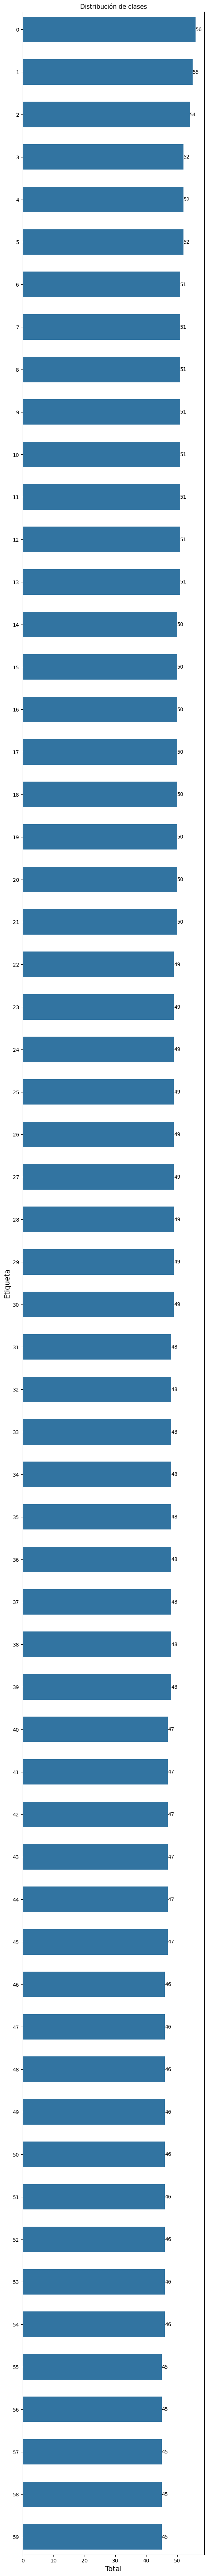

In [9]:
# Se crea DataFrame a partir de un Dataset
df_entrenamiento = pd.DataFrame(dataset_tokenizado_roberta_2['train'])

# Se ordenan las etiquetas
df_entrenamiento.sort_values(by=['label'], inplace=True)

figura, ejes = plt.subplots()
figura.set_figheight(90)
sns.barplot(y=df_entrenamiento['label'].unique(), x=df_entrenamiento['label'].value_counts(), orient='h', width=0.6)
ejes.set_xlabel('Total', fontsize=14)
ejes.set_ylabel('Etiqueta', fontsize=14)
ejes.set_title('Distribución de clases')
ejes.bar_label(ejes.containers[0])
plt.margins(y=0.002, tight=True)
plt.show()

In [14]:
training_args_roberta_2 = TrainingArguments(
    output_dir=nombre_modelo_roberta_2 + '-custom-lora',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch',
    push_to_hub=False
)

trainer_roberta_2 = Trainer(
    model=modelo_peft_roberta_2,
    args=training_args_roberta_2,
    train_dataset=dataset_tokenizado_roberta_2['train'],
    eval_dataset=dataset_tokenizado_roberta_2['test'],
    tokenizer=tokenizador_roberta_2,
    data_collator=data_collator_roberta_2,
    compute_metrics=obtener_metricas
)


C:\Users\jmarrieta\AppData\Local\Temp\ipykernel_28960\4046720085.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta_2 = Trainer(


In [ ]:
# Se realiza el entrenamiento y guarda el modelo
resultados_entrenamiento_roberta_2 = trainer_roberta_2.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,3.734524,0.173735,0.195017,0.173735,0.152181


C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jmarrieta\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Se guardan los modelos y el tokenizador, tanto de forma separada como de manera conjunta para su uso posterior
trainer_roberta_2.save_model()
modelo_peft.save_pretrained(nombre_modelo + '_2_peft')
modelo_peft_roberta_2_fusionado = modelo_peft_roberta_2.merge_and_unload()
modelo_peft_roberta_2_fusionado.save_pretrained('roberta-large-bne-massive_peft_fusionado_2')

# Se guarda también el tokenizador
tokenizador_roberta_2.save_pretrained('roberta-large-bne-massive_peft_fusionado_2')